<a href="https://colab.research.google.com/github/DJCordhose/ai/blob/master/notebooks/rl/berater-v11-lower.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Berater Environment v11 lower

## less stops per consultant


## Installation (required for colab)

In [0]:
!pip install git+https://github.com/openai/baselines >/dev/null
!pip install gym >/dev/null

## Environment

In [0]:
import numpy as np
import random

import gym
from gym.utils import seeding
from gym import spaces

def state_name_to_int(state):
    state_name_map = {
        'S': 0,
        'A': 1,
        'B': 2,
        'C': 3,
        'D': 4,
        'E': 5,
        'F': 6,
        'G': 7,
        'H': 8,
        'K': 9,
        'L': 10,
        'M': 11,
        'N': 12,
        'O': 13
    }
    return state_name_map[state]

def int_to_state_name(state_as_int):
    state_map = {
        0: 'S',
        1: 'A',
        2: 'B',
        3: 'C',
        4: 'D',
        5: 'E',
        6: 'F',
        7: 'G',
        8: 'H',
        9: 'K',
        10: 'L',
        11: 'M',
        12: 'N',
        13: 'O'
    }
    return state_map[state_as_int]
    
class BeraterEnv(gym.Env):
    """
    The Berater Problem

    Actions: 
    There are 4 discrete deterministic actions, each choosing one direction
    """
    metadata = {'render.modes': ['ansi']}
    
    showStep = False
    showDone = True
    envEpisodeModulo = 100

    def __init__(self):
#         self.map = {
#             'S': [('A', 100), ('B', 400), ('C', 200 )],
#             'A': [('B', 250), ('C', 400), ('S', 100 )],
#             'B': [('A', 250), ('C', 250), ('S', 400 )],
#             'C': [('A', 400), ('B', 250), ('S', 200 )]
#         }
        self.map = {
            'S': [('A', 300), ('B', 100), ('C', 200 )],
            'A': [('S', 300), ('B', 100), ('E', 100 ), ('D', 100 )],
            'B': [('S', 100), ('A', 100), ('C', 50 ), ('K', 200 )],
            'C': [('S', 200), ('B', 50), ('M', 100 ), ('L', 200 )],
            'D': [('A', 100), ('F', 50)],
            'E': [('A', 100), ('F', 100), ('H', 100)],
            'F': [('D', 50), ('E', 100), ('G', 200)],
            'G': [('F', 200), ('O', 300)],
            'H': [('E', 100), ('K', 300)],
            'K': [('B', 200), ('H', 300)],
            'L': [('C', 200), ('M', 50)],
            'M': [('C', 100), ('L', 50), ('N', 100)],
            'N': [('M', 100), ('O', 100)],
            'O': [('N', 100), ('G', 300)]
        }
        max_paths = 4
        self.action_space = spaces.Discrete(max_paths)
      
        positions = len(self.map)
        # observations: position, reward of all 4 local paths, rest reward of all locations
        # non existing path is -1000 and no position change
        # look at what #getObservation returns if you are confused
        low = np.append(np.append([0], np.full(max_paths, -1000)), np.full(positions, 0))
        high = np.append(np.append([positions - 1], np.full(max_paths, 1000)), np.full(positions, 1000))
        self.observation_space = spaces.Box(low=low,
                                             high=high,
                                             dtype=np.float32)
        self.reward_range = (-1, 1)

        self.totalReward = 0
        self.stepCount = 0
        self.isDone = False

        self.envReward = 0
        self.envEpisodeCount = 0
        self.envStepCount = 0

        self.reset()
        self.optimum = self.calculate_customers_reward()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def iterate_path(self, state, action):
        paths = self.map[state]
        if action < len(paths):
          return paths[action]
        else:
          # sorry, no such action, stay where you are and pay a high penalty
          return (state, 1000)
      
    def step(self, action):
        destination, cost = self.iterate_path(self.state, action)
        lastState = self.state
        customerReward = self.customer_reward[destination]
        reward = (customerReward - cost) / self.optimum

        self.state = destination
        self.customer_visited(destination)
        done = destination == 'S' and self.all_customers_visited()

        stateAsInt = state_name_to_int(self.state)
        self.totalReward += reward
        self.stepCount += 1
        self.envReward += reward
        self.envStepCount += 1

        if self.showStep:
            print( "Episode: " + ("%4.0f  " % self.envEpisodeCount) + 
                   " Step: " + ("%4.0f  " % self.stepCount) + 
                   lastState + ' --' + str(action) + '-> ' + self.state + 
                   ' R=' + ("% 2.2f" % reward) + ' totalR=' + ("% 3.2f" % self.totalReward) + 
                   ' cost=' + ("%4.0f" % cost) + ' customerR=' + ("%4.0f" % customerReward) + ' optimum=' + ("%4.0f" % self.optimum)      
                   )

        if done and not self.isDone:
            self.envEpisodeCount += 1
            if BeraterEnv.showDone:
                episodes = BeraterEnv.envEpisodeModulo
                if (self.envEpisodeCount % BeraterEnv.envEpisodeModulo != 0):
                    episodes = self.envEpisodeCount % BeraterEnv.envEpisodeModulo
                print( "Done: " + 
                        ("episodes=%6.0f  " % self.envEpisodeCount) + 
                        ("avgSteps=%6.2f  " % (self.envStepCount/episodes)) + 
                        ("avgTotalReward=% 3.2f" % (self.envReward/episodes) )
                        )
                if (self.envEpisodeCount%BeraterEnv.envEpisodeModulo) == 0:
                    self.envReward = 0
                    self.envStepCount = 0

        self.isDone = done
        observation = self.getObservation(stateAsInt)
        info = {"from": self.state, "to": destination}

        return observation, reward, done, info

    def getObservation(self, position):
        result = np.array([ position, 
                               self.getPathObservation(position, 0),
                               self.getPathObservation(position, 1),
                               self.getPathObservation(position, 2),
                               self.getPathObservation(position, 3)
                              ],
                             dtype=np.float32)
        all_rest_rewards = list(self.customer_reward.values())
        result = np.append(result, all_rest_rewards)
        return result

    def getPathObservation(self, position, path):
        source = int_to_state_name(position)
        paths = self.map[self.state]
        if path < len(paths):
          target, cost = paths[path]
          reward = self.customer_reward[target] 
          result = reward - cost
        else:
          result = -1000

        return result

    def customer_visited(self, customer):
        self.customer_reward[customer] = 0

    def all_customers_visited(self):
        return self.calculate_customers_reward() == 0

    def calculate_customers_reward(self):
        sum = 0
        for value in self.customer_reward.values():
            sum += value
        return sum

      
    def modulate_reward(self):
      number_of_customers = len(self.map) - 1
      number_per_consultant = int(number_of_customers/3)
      self.customer_reward = {
          'S': 0
      }
      for customer_nr in range(1, number_of_customers + 1):
        self.customer_reward[int_to_state_name(customer_nr)] = 0
      
      # every consultant only visits a few random customers
      samples = random.sample(range(1, number_of_customers + 1), k=number_per_consultant)
      key_list = list(self.customer_reward.keys())
      for sample in samples:
        self.customer_reward[key_list[sample]] = 1000

      
    def reset(self):
        self.totalReward = 0
        self.stepCount = 0
        self.isDone = False

        self.modulate_reward()
        self.state = 'S'
        return self.getObservation(state_name_to_int(self.state))
      
    def render(self):
      print(self.customer_reward)

In [3]:
env = BeraterEnv()
print(env.reset())
print(env.customer_reward)

[    0.  -300.  -100.  -200. -1000.     0.     0.     0.     0.     0.
  1000.     0.  1000.     0.  1000.     0.  1000.     0.     0.]
{'S': 0, 'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 1000, 'F': 0, 'G': 1000, 'H': 0, 'K': 1000, 'L': 0, 'M': 1000, 'N': 0, 'O': 0}


# Try out Environment

In [4]:
BeraterEnv.showStep = True
BeraterEnv.showDone = True

env = BeraterEnv()
print(env)
observation = env.reset()
print(observation)

for t in range(1000):
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if done:
        print("Episode finished after {} timesteps".format(t+1))
        break
env.close()
print(observation)

<BeraterEnv instance>
[    0.  -300.   900.  -200. -1000.     0.     0.  1000.     0.  1000.
     0.     0.     0.  1000.     0.     0.     0.  1000.     0.]
Episode:    0   Step:    1  S --0-> A R=-0.07 totalR=-0.07 cost= 300 customerR=   0 optimum=4000
Episode:    0   Step:    2  A --3-> D R= 0.23 totalR= 0.15 cost= 100 customerR=1000 optimum=4000
Episode:    0   Step:    3  D --1-> F R=-0.01 totalR= 0.14 cost=  50 customerR=   0 optimum=4000
Episode:    0   Step:    4  F --0-> D R=-0.01 totalR= 0.12 cost=  50 customerR=   0 optimum=4000
Episode:    0   Step:    5  D --3-> D R=-0.25 totalR=-0.12 cost=1000 customerR=   0 optimum=4000
Episode:    0   Step:    6  D --3-> D R=-0.25 totalR=-0.38 cost=1000 customerR=   0 optimum=4000
Episode:    0   Step:    7  D --3-> D R=-0.25 totalR=-0.62 cost=1000 customerR=   0 optimum=4000
Episode:    0   Step:    8  D --3-> D R=-0.25 totalR=-0.88 cost=1000 customerR=   0 optimum=4000
Episode:    0   Step:    9  D --1-> F R=-0.01 totalR=-0.89 cost=  

## Baseline

In [0]:
from copy import deepcopy
import json

class Baseline():

  def __init__(self, env, max_reward, verbose=1):
    self.env = env
    self.max_reward = max_reward
    self.verbose = verbose
    self.reset()

  def reset(self):
    self.map = self.env.map
    self.rewards = self.env.customer_reward.copy()
    
  def as_string(self, state):
    # reward/cost does not hurt, but is useless, path obsucres same state
    new_state = {
        'rewards': state['rewards'],
        'position': state['position']
    }
    return json.dumps(new_state, sort_keys=True)
  
  def is_goal(self, state):
    if state['position'] != 'S': return False
    for reward in state['rewards'].values():
      if reward != 0: return False
    return True
    

  def expand(self, state):
    states = []
    for position, cost in self.map[state['position']]:
      new_state = deepcopy(state)
      new_state['position'] = position
      new_state['rewards'][position] = 0
      reward = state['rewards'][position]
      new_state['reward'] += reward
      new_state['cost'] += cost
      new_state['path'].append(position)
      states.append(new_state)
    return states

  def search(self, root, max_depth = 25):
      closed = set()
      open = [root]

      while open:
          state = open.pop(0)
          if self.as_string(state) in closed: continue  

          closed.add(self.as_string(state))

          depth = len(state['path'])
          if depth > max_depth:
            if self.verbose > 0:
              print("Visited:", len(closed))
              print("Reached max depth, without reaching goal")
            return None

          if self.is_goal(state):
            scaled_reward = (state['reward'] - state['cost']) / self.max_reward
            state['scaled_reward'] = scaled_reward
            if self.verbose > 0:
              print("Scaled reward:", scaled_reward)            
              print("Perfect path", state['path'])
            return state

          expanded = self.expand(state)
          open += expanded
          # make this best first
          open.sort(key=lambda state: state['cost'])
        
  def find_optimum(self):
    initial_state = {
        'rewards': self.rewards.copy(),
        'position': 'S',
        'reward': 0,
        'cost': 0,
        'path': ['S']
    }
    return self.search(initial_state)
  
  def benchmark(self, model, sample_runs=100):
    self.verbose = 0
    BeraterEnv.showStep = False
    BeraterEnv.showDone = False

    perfect_rewards = []
    model_rewards = []
    for run in range(sample_runs):
      observation = self.env.reset()
      self.reset()
      
      optimum_state = self.find_optimum()
      perfect_rewards.append(optimum_state['scaled_reward'])
      
      state = np.zeros((1, 2*128))
      dones = np.zeros((1))

      for t in range(1000):
        actions, _, state, _ = model.step(observation, S=state, M=dones)
        observation, reward, done, info = self.env.step(actions[0])
        if done:
          break
      model_rewards.append(env.totalReward)
    return perfect_rewards, model_rewards
  
  def score(self, model, sample_runs=100):
    perfect_rewards, model_rewards = self.benchmark(model, sample_runs=100)
    
    perfect_score_mean, perfect_score_std = np.array(perfect_rewards).mean(), np.array(perfect_rewards).std()
    test_score_mean, test_score_std = np.array(model_rewards).mean(), np.array(model_rewards).std()
    
    return perfect_score_mean, perfect_score_std, test_score_mean, test_score_std

# Train model

Estimation
* total cost when travelling all paths (back and forth): 2500
* all rewards: 6000
* but: rewards are much more sparse while routes stay the same, maybe expect less
* estimate: no illegal moves and between
  * half the travel cost: (6000 - 1250) / 6000 = .79
  * and full traval cost (6000 - 2500) / 6000 = 0.58
* additionally: the agent only sees very little of the whole scenario
  * changes with every episode
  * was ok when network can learn fixed scenario


In [0]:
!rm -r logs
!mkdir logs
!mkdir logs/berater

In [7]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

1.12.0


### Step 1: Extract MLP builder from openai sources

In [0]:
# copied from https://github.com/openai/baselines/blob/master/baselines/a2c/utils.py

def ortho_init(scale=1.0):
    def _ortho_init(shape, dtype, partition_info=None):
        #lasagne ortho init for tf
        shape = tuple(shape)
        if len(shape) == 2:
            flat_shape = shape
        elif len(shape) == 4: # assumes NHWC
            flat_shape = (np.prod(shape[:-1]), shape[-1])
        else:
            raise NotImplementedError
        a = np.random.normal(0.0, 1.0, flat_shape)
        u, _, v = np.linalg.svd(a, full_matrices=False)
        q = u if u.shape == flat_shape else v # pick the one with the correct shape
        q = q.reshape(shape)
        return (scale * q[:shape[0], :shape[1]]).astype(np.float32)
    return _ortho_init      

def fc(x, scope, nh, *, init_scale=1.0, init_bias=0.0):
    with tf.variable_scope(scope):
        nin = x.get_shape()[1].value
        w = tf.get_variable("w", [nin, nh], initializer=ortho_init(init_scale))
        b = tf.get_variable("b", [nh], initializer=tf.constant_initializer(init_bias))
        return tf.matmul(x, w)+b
      

# copied from https://github.com/openai/baselines/blob/master/baselines/common/models.py#L31
def mlp(num_layers=2, num_hidden=64, activation=tf.tanh, layer_norm=False):
    """
    Stack of fully-connected layers to be used in a policy / q-function approximator

    Parameters:
    ----------

    num_layers: int                 number of fully-connected layers (default: 2)

    num_hidden: int                 size of fully-connected layers (default: 64)

    activation:                     activation function (default: tf.tanh)

    Returns:
    -------

    function that builds fully connected network with a given input tensor / placeholder
    """
    def network_fn(X):
#         print('network_fn called')
#         Tensor("ppo2_model_4/Ob:0", shape=(1, 19), dtype=float32)
#         Tensor("ppo2_model_4/Ob_1:0", shape=(512, 19), dtype=float32)
#         print (X)
        h = tf.layers.flatten(X)
        for i in range(num_layers):
            h = fc(h, 'mlp_fc{}'.format(i), nh=num_hidden, init_scale=np.sqrt(2))
            if layer_norm:
                h = tf.contrib.layers.layer_norm(h, center=True, scale=True)
            h = activation(h)
          
#         Tensor("ppo2_model_4/pi/Tanh_2:0", shape=(1, 500), dtype=float32)
#         Tensor("ppo2_model_4/pi_2/Tanh_2:0", shape=(512, 500), dtype=float32)
#         print(h)
        return h

    return network_fn


### Step 2: Replace exotic parts

Steps:
1. Low level matmul replaced with dense layer (no need for custom code here)
    * https://www.tensorflow.org/api_docs/python/tf/layers
    * https://www.tensorflow.org/api_docs/python/tf/layers/Dense

1. initializer changed to best practice glorot uniform, but does not give reliable results, so use seed
1. use relu activations (should train faster)
1. standard batch normalization does not train with any configuration (no idea why), so we need to keep layer normalization
1.Dropout and L2 would be nice as well, but easy to do within the boundaries of the OpenAI framework:  https://stackoverflow.com/questions/38292760/tensorflow-introducing-both-l2-regularization-and-dropout-into-the-network-do

#### Alternative: Using Keras API

Not done here, as no big benefit expected and would need to be integrated into surrounding low level tensorflow model. Need to reuse session. If you want to do this, be sure to check at least the first link

* using Keras within TensorFlow model: https://blog.keras.io/keras-as-a-simplified-interface-to-tensorflow-tutorial.html
* https://stackoverflow.com/questions/46790506/calling-a-keras-model-on-a-tensorflow-tensor-but-keep-weights
* https://www.tensorflow.org/api_docs/python/tf/get_default_session
* https://www.tensorflow.org/api_docs/python/tf/keras/backend/set_session

In [0]:
# first the dense layer
def mlp(num_layers=2, num_hidden=64, activation=tf.tanh, layer_norm=False):
    def network_fn(X):
        h = tf.layers.flatten(X)
        for i in range(num_layers):
            h = tf.layers.dense(h, units=num_hidden, kernel_initializer=ortho_init(np.sqrt(2)))
#             h = fc(h, 'mlp_fc{}'.format(i), nh=num_hidden, init_scale=np.sqrt(2))
            if layer_norm:
                h = tf.contrib.layers.layer_norm(h, center=True, scale=True)
            h = activation(h)
        return h

    return network_fn

In [0]:
# then initializer, relu activations
def mlp(num_layers=2, num_hidden=64, activation=tf.nn.relu, layer_norm=False):
    def network_fn(X):
        h = tf.layers.flatten(X)
        for i in range(num_layers):
            h = tf.layers.dense(h, units=num_hidden, kernel_initializer=tf.initializers.glorot_uniform(seed=13))
            if layer_norm:
#               h = tf.layers.batch_normalization(h, center=True, scale=True)
              h = tf.contrib.layers.layer_norm(h, center=True, scale=True)
            h = activation(h)
        return h

    return network_fn

In [11]:
%%time

# https://github.com/openai/baselines/blob/master/baselines/deepq/experiments/train_pong.py
# log_dir = logger.get_dir()
log_dir = '/content/logs/berater/'

import gym
from baselines import bench
from baselines import logger

from baselines.common.vec_env.dummy_vec_env import DummyVecEnv
from baselines.common.vec_env.vec_monitor import VecMonitor
from baselines.ppo2 import ppo2

BeraterEnv.showStep = False
BeraterEnv.showDone = False

env = BeraterEnv()

wrapped_env = DummyVecEnv([lambda: BeraterEnv()])
monitored_env = VecMonitor(wrapped_env, log_dir)

# https://github.com/openai/baselines/blob/master/baselines/ppo2/ppo2.py
# https://github.com/openai/baselines/blob/master/baselines/common/models.py#L30
# https://arxiv.org/abs/1607.06450 for layer_norm

# lr linear from lr=1e-2 to lr=1e-4 (default lr=3e-4)
def lr_range(frac):
  # we get the remaining updates between 1 and 0
  start_lr = 1e-2
  end_lr = 1e-4
  diff_lr = start_lr - end_lr
  lr = end_lr + diff_lr * frac
  return lr
  
network = mlp(num_hidden=500, num_layers=3, layer_norm=True)
  
model = ppo2.learn(
    env=monitored_env,
    network=network,
    lr=lr_range,
    gamma=1.0,
    ent_coef=0.05,
    total_timesteps=1000000)

# model = ppo2.learn(
#     env=monitored_env,
#     network='mlp',
#     num_hidden=500,
#     num_layers=3,
#     layer_norm=True,
#     lr=lr_range,
#     gamma=1.0,
#     ent_coef=0.05,
#     total_timesteps=500000)


# model.save('berater-ppo-v11.pkl')
monitored_env.close()

Logging to /tmp/openai-2019-02-02-11-53-30-053080
-----------------------------------
| approxkl           | 2.941825   |
| clipfrac           | 0.8652344  |
| eplenmean          | 103        |
| eprewmean          | -9.56776   |
| explained_variance | -0.0733    |
| fps                | 229        |
| nupdates           | 1          |
| policy_entropy     | 0.7919297  |
| policy_loss        | 0.22188225 |
| serial_timesteps   | 2048       |
| time_elapsed       | 8.93       |
| total_timesteps    | 2048       |
| value_loss         | 5.650091   |
-----------------------------------
-------------------------------------
| approxkl           | 0.011109623  |
| clipfrac           | 0.17163086   |
| eplenmean          | 197          |
| eprewmean          | -24.284218   |
| explained_variance | 0.357        |
| fps                | 242          |
| nupdates           | 10           |
| policy_entropy     | 1.2311755    |
| policy_loss        | 0.0035450112 |
| serial_timesteps   | 20480  

### Visualizing Results

https://github.com/openai/baselines/blob/master/docs/viz/viz.ipynb

In [0]:
# !ls -l $log_dir

/usr/local/lib/python3.6/dist-packages/baselines/bench/monitor.py:164: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.headers = headers # HACK to preserve backwards compatibility


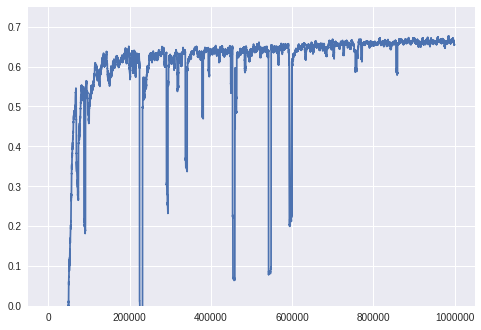

In [13]:
from baselines.common import plot_util as pu
results = pu.load_results(log_dir)

import matplotlib.pyplot as plt
import numpy as np
r = results[0]
plt.ylim(0, .75)
# plt.plot(np.cumsum(r.monitor.l), r.monitor.r)
plt.plot(np.cumsum(r.monitor.l), pu.smooth(r.monitor.r, radius=100))

# Enjoy model

In [21]:
import numpy as np 

observation = env.reset()
env.render()
baseline = Baseline(env, max_reward=4000)

{'S': 0, 'A': 0, 'B': 1000, 'C': 1000, 'D': 0, 'E': 0, 'F': 0, 'G': 0, 'H': 0, 'K': 0, 'L': 0, 'M': 0, 'N': 1000, 'O': 1000}


In [22]:
state = np.zeros((1, 2*128))
dones = np.zeros((1))

BeraterEnv.showStep = True
BeraterEnv.showDone = False

for t in range(1000):
    actions, _, state, _ = model.step(observation, S=state, M=dones)
    observation, reward, done, info = env.step(actions[0])
    if done:
        print("Episode finished after {} timesteps, reward={}".format(t+1, env.totalReward))
        break
env.close()

Episode:  101   Step:    1  S --1-> B R= 0.23 totalR= 0.23 cost= 100 customerR=1000 optimum=4000
Episode:  101   Step:    2  B --2-> C R= 0.24 totalR= 0.46 cost=  50 customerR=1000 optimum=4000
Episode:  101   Step:    3  C --2-> M R=-0.03 totalR= 0.44 cost= 100 customerR=   0 optimum=4000
Episode:  101   Step:    4  M --2-> N R= 0.23 totalR= 0.66 cost= 100 customerR=1000 optimum=4000
Episode:  101   Step:    5  N --1-> O R= 0.23 totalR= 0.89 cost= 100 customerR=1000 optimum=4000
Episode:  101   Step:    6  O --0-> N R=-0.03 totalR= 0.86 cost= 100 customerR=   0 optimum=4000
Episode:  101   Step:    7  N --0-> M R=-0.03 totalR= 0.84 cost= 100 customerR=   0 optimum=4000
Episode:  101   Step:    8  M --0-> C R=-0.03 totalR= 0.81 cost= 100 customerR=   0 optimum=4000
Episode:  101   Step:    9  C --1-> B R=-0.01 totalR= 0.80 cost=  50 customerR=   0 optimum=4000
Episode:  101   Step:   10  B --0-> S R=-0.03 totalR= 0.77 cost= 100 customerR=   0 optimum=4000
Episode finished after 10 time

In [23]:
%time baseline.find_optimum()

Scaled reward: 0.775
Perfect path ['S', 'B', 'C', 'M', 'N', 'O', 'N', 'M', 'C', 'B', 'S']
CPU times: user 12.7 ms, sys: 2.11 ms, total: 14.8 ms
Wall time: 16 ms


{'cost': 900,
 'path': ['S', 'B', 'C', 'M', 'N', 'O', 'N', 'M', 'C', 'B', 'S'],
 'position': 'S',
 'reward': 4000,
 'rewards': {'A': 0,
  'B': 0,
  'C': 0,
  'D': 0,
  'E': 0,
  'F': 0,
  'G': 0,
  'H': 0,
  'K': 0,
  'L': 0,
  'M': 0,
  'N': 0,
  'O': 0,
  'S': 0},
 'scaled_reward': 0.775}

## Evaluation

In [0]:
baseline = Baseline(env, max_reward=4000)
perfect_score_mean, perfect_score_std, test_score_mean, test_score_std = baseline.score(model, sample_runs=100)

In [25]:
# perfect scores
perfect_score_mean, perfect_score_std

(0.675375, 0.06605998694368626)

In [26]:
# test scores for our model
test_score_mean, test_score_std

(0.6703749999999998, 0.06795345373857023)